In [3]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm, tnrange, tqdm_notebook
import seaborn as sns
import os

pd.set_option('display.max_rows', None)


# # Load the results
results_folder = 'results/'
save_folder = 'figures/'

def load_scores_loop(experiments, task_id_lists, base_save_folder, num_runs):
    results = []
    for taskid in task_id_lists:
        for run in range(num_runs):
            for exp in experiments:
                save_folder = f"{base_save_folder}/{exp}_{taskid}_{run}"
                
                if not os.path.exists(save_folder):
                    r = {'exp_name': exp, 'taskid': taskid, 'run': run, 'remaining': True, 'failed': False, 'completed': False, 'timeout':False, 'error':np.nan}
                    results.append(r)
                else:
                    # Load the results
                    results_file = f"{save_folder}/scores.pkl"
                    
                    if os.path.exists(results_file):
                        r = pickle.load(open(results_file,'rb'))
                        r['completed'] = True
                        r['remaining'] = False
                        r['failed'] = False
                        r['error'] = np.nan
                        r['timeout'] = False
                    else:
                        results_file = f"{save_folder}/failed.pkl"
                        if os.path.exists(results_file):
                            r = pickle.load(open(results_file,'rb'))
                            r['failed'] = True
                            r['completed'] = False
                            r['remaining'] = False
                            r['timeout'] = False
                        else:
                            r = {'exp_name': exp, 'taskid': taskid, 'run': run, 'timeout': True}
                            r['failed'] = False
                            r['completed'] = False
                            r['remaining'] = False
                    
                    results.append(r)


    df = pd.DataFrame.from_records(results)
    del results
    return df

binary_task_ids = [189865,
                    167200,
                    126026,
                    189860,
                    75127,
                    189862,
                    75105,
                    168798,
                    126029,
                    168796,
                    167190,
                    189866,
                    167104,
                    167083,
                    167184,
                    126025,
                    75097, 
                    167181,
                    168797,
                    189861,
                    167161,
                    167149,
                    ]

multiclass_task_ids  = [
                            168794,
                            189873,
                            167152,
                            189909,
                            189872,
                            168795, #This one has fewer than 10 instances of a class
                            167185,
                            189905,
                            189874,
                            75193,
                            167168,
                            168793,
                            189906,
                            167201,
                            189908,
                            168792,
                            189871
                            ]


multiclass_exps = ['tpot_untimed_30_gen_neg_log_loss', 'tpot2_untimed_30_gen_neg_log_loss']


binary_exps = ['tpot_untimed_30_gen_roc_auc','tpot2_untimed_30_gen_roc_auc']


rename_exp_keys = {'tpot_untimed_30_gen_neg_log_loss' :'TPOT1',
                    'tpot2_untimed_30_gen_neg_log_loss':'TPOT2',
                    'tpot_untimed_30_gen_roc_auc':'TPOT1',
                    'tpot2_untimed_30_gen_roc_auc':'TPOT2',
                    }



exp_palette = {"TPOT1": "#3498db", "TPOT2": "#e74c3c"}

binary_df = load_scores_loop(binary_exps, binary_task_ids, f'{results_folder}/results_binary', 5)
multiclass_df = load_scores_loop(multiclass_exps, multiclass_task_ids,  f'{results_folder}/results_multi', 5)

df = pd.concat([binary_df, multiclass_df])

#add a column to indicate if the taskid is binary or multiclass
df['binary'] = df['taskid'].isin(binary_task_ids)
df['duration'] = df['duration']/60.0

df['selected_score'] = df.apply(lambda row: row['logloss']*-1 if row['binary']==False else row['auroc'], axis=1)
df['grouped_exp_name'] = df['exp_name'].replace(rename_exp_keys)

df['failed'] = ~df['error'].isnull()

In [4]:
# count number of failed and not failed per grouped_exp_name and taskid
df_failed = df.groupby(['grouped_exp_name', 'taskid'])['failed','timeout','completed','remaining'].sum().reset_index()
df_failed.rename(columns={'failed':'failed_count'}, inplace=True)
df_failed.rename(columns={'timeout':'timeout_count'}, inplace=True)
df_failed.rename(columns={'completed':'completed_count'}, inplace=True)
df_failed.rename(columns={'remaining':'remaining_count'}, inplace=True)

df_failed
#get totals by grouped_exp_name

df_failed_totals = df_failed.groupby(['grouped_exp_name']).sum().reset_index()
df_failed_totals.drop(columns=['taskid'], inplace=True)
df_failed_totals

/tmp/ipykernel_70124/284557698.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_failed = df.groupby(['grouped_exp_name', 'taskid'])['failed','timeout','completed','remaining'].sum().reset_index()


,grouped_exp_name,failed_count,timeout_count,completed_count,remaining_count
0,TPOT1,2,39,154,0
1,TPOT2,0,6,189,0


In [10]:
df_failed.groupby(['taskid']).sum().reset_index()

/tmp/ipykernel_70124/585584874.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_failed.groupby(['taskid']).sum().reset_index()


,taskid,failed_count,timeout_count,completed_count,remaining_count
0,75097,0,2,8,0
1,75105,1,1,8,0
2,75127,0,5,5,0
3,75193,0,4,6,0
4,126025,0,0,10,0
5,126026,0,0,10,0
6,126029,0,0,10,0
7,167083,0,0,10,0
8,167104,0,0,10,0
9,167149,0,1,9,0


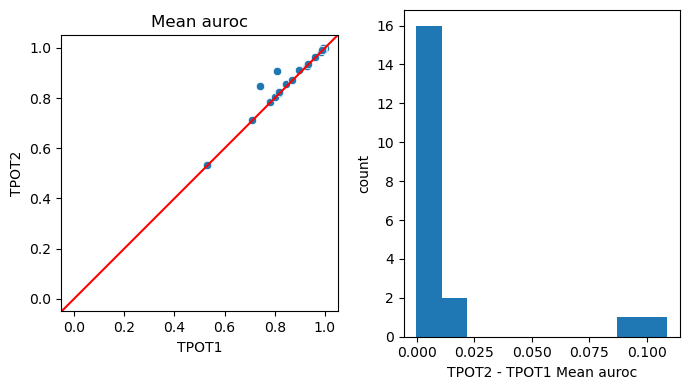

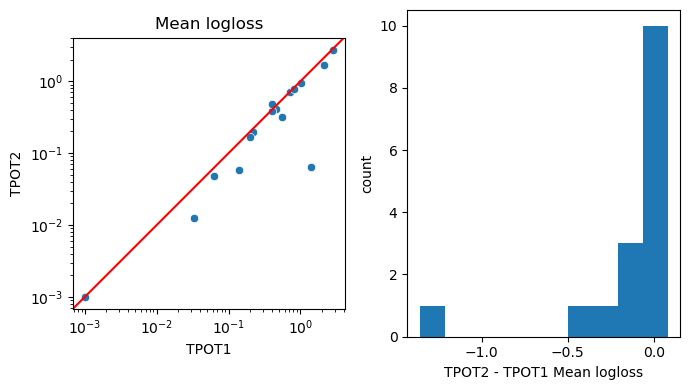

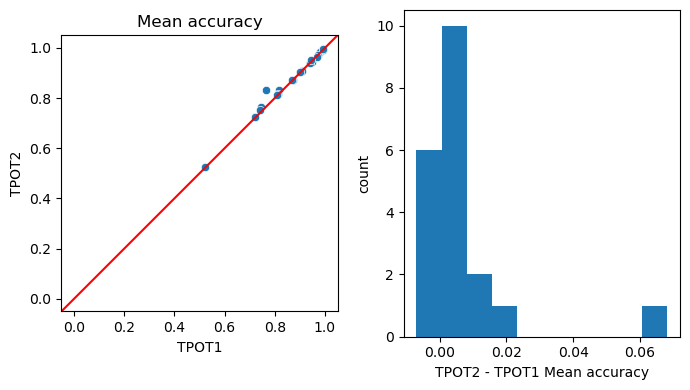

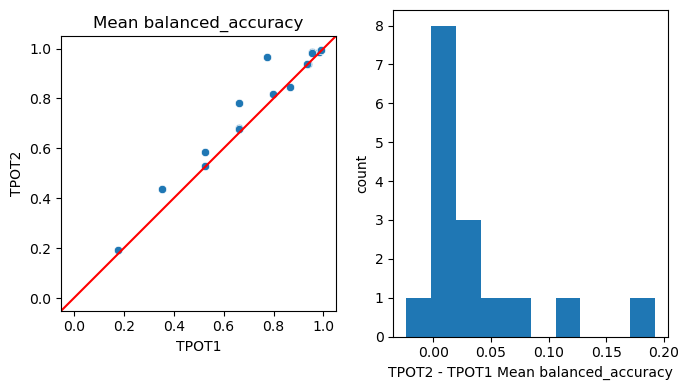

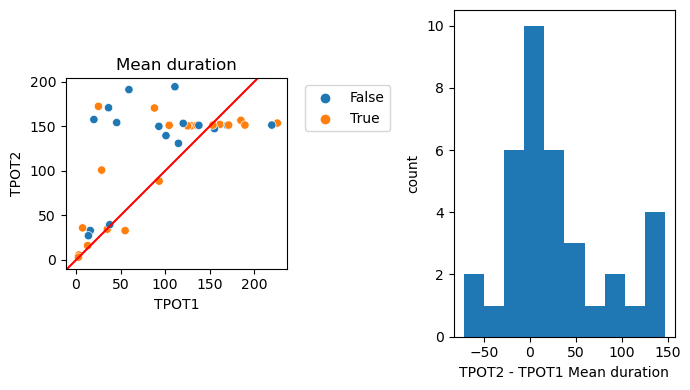

In [12]:
def make_scatter_and_diff_plot(df, m1, m2, metric, x='grouped_exp_name', log_scale=False, save_folder=None, name=None, binary_hue=False, binary_task_ids=binary_task_ids):
    df = df.copy()


    dftmp = df.copy()
    df_summary = dftmp.groupby(['taskid', x])[metric].describe().reset_index()
    df_summary['binary'] = df_summary['taskid'].isin(binary_task_ids)
    df_summary 
    piv = df_summary.pivot_table(index=x, columns='taskid', values='mean', aggfunc=np.mean).T.reset_index(inplace=False)
    piv['binary'] = piv['taskid'].isin(binary_task_ids)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,4))
    if binary_hue:
        hue = 'binary'
    else:
        hue = None
    sns.scatterplot(data=piv, x=m1, y=m2, hue=hue, ax=ax1)
    ax1.axline([0, 0], [1, 1],c='r')
    ax1.set_aspect('equal', adjustable='box')
    ax1.set_xlabel(m1)
    ax1.set_ylabel(m2)
    ax1.set_title(f'Mean {metric}')
    if log_scale:
        ax1.set_yscale('log')
        ax1.set_xscale('log')
    if binary_hue:
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    diffs = piv[m2] - piv[m1]
    ax2.hist(diffs)
    ax2.set_xlabel(f'{m2} - {m1} Mean {metric}')
    ax2.set_ylabel('count')
    plt.tight_layout()

    if save_folder is not None:
        plt.savefig(f'{save_folder}/{name}_{metric}_{m1}_{m2}_scatter.svg', bbox_inches='tight')
        plt.savefig(f'{save_folder}/{name}_{metric}_{m1}_{m2}_scatter.png', bbox_inches='tight')


df = df[df['completed']==True]

make_scatter_and_diff_plot(df[df['binary']==True], m1 = 'TPOT1', m2 = 'TPOT2',  metric='auroc', log_scale=False, save_folder=save_folder, name='Binary')

make_scatter_and_diff_plot(df[df['binary']==False], m1 = 'TPOT1', m2 = 'TPOT2',  metric='logloss', log_scale=True, save_folder=save_folder, name='Multiclass')

make_scatter_and_diff_plot(df[df['binary']==True], m1 = 'TPOT1', m2 = 'TPOT2',  metric='accuracy', log_scale=False, save_folder=save_folder, name='Binary')

make_scatter_and_diff_plot(df[df['binary']==False], m1 = 'TPOT1', m2 = 'TPOT2',  metric='balanced_accuracy', log_scale=False, save_folder=save_folder, name='Multiclass')

make_scatter_and_diff_plot(df, m1 = 'TPOT1', m2 = 'TPOT2',  metric='duration', log_scale=False, save_folder=save_folder, name='duration', binary_hue=True)

/tmp/ipykernel_70124/1443055911.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16)


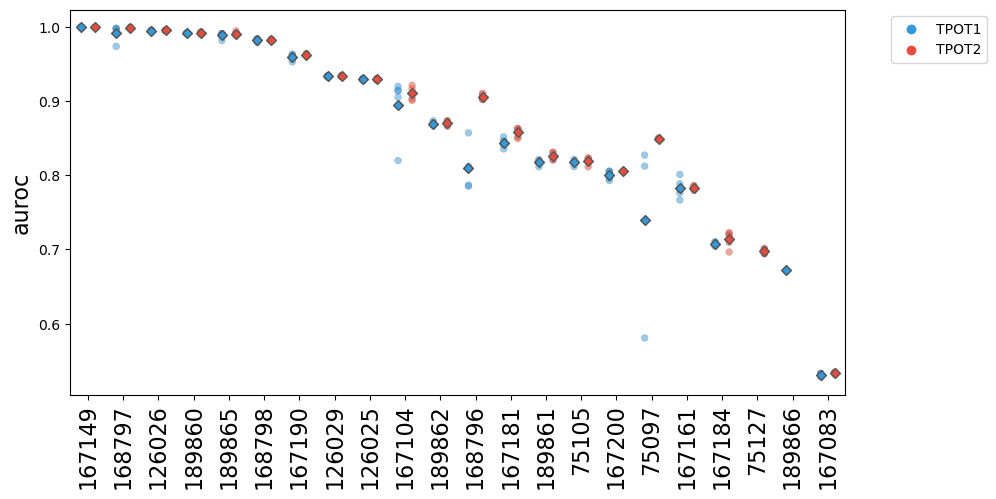

/tmp/ipykernel_70124/1443055911.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16)


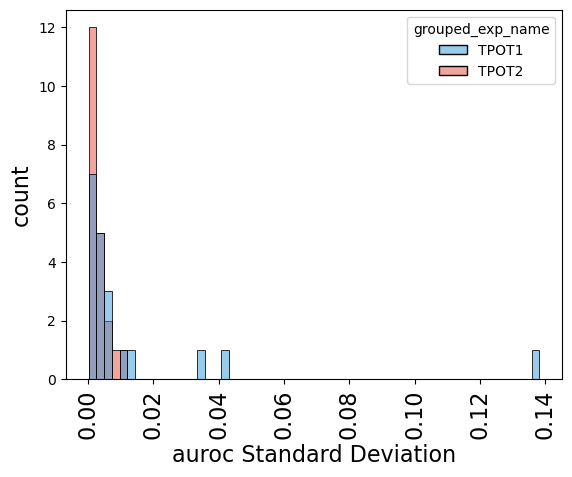

/tmp/ipykernel_70124/1443055911.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16)


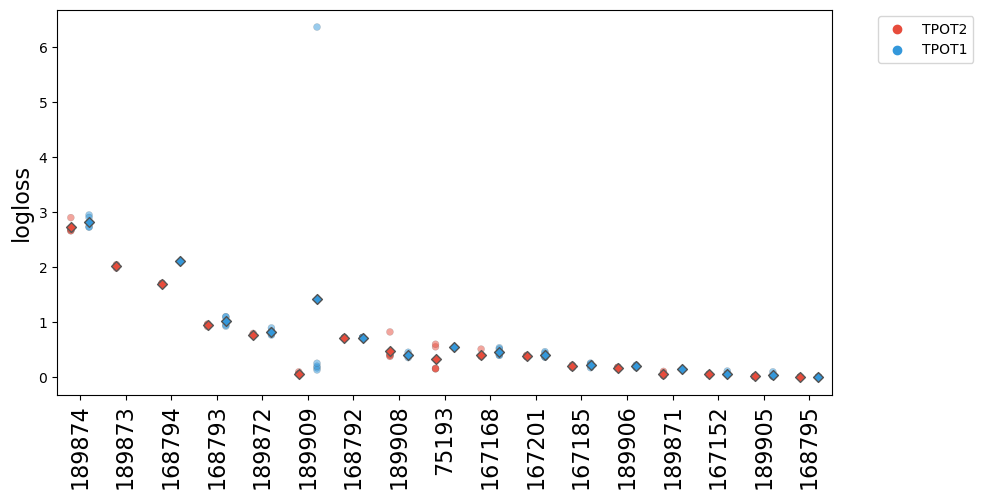

/tmp/ipykernel_70124/1443055911.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16)


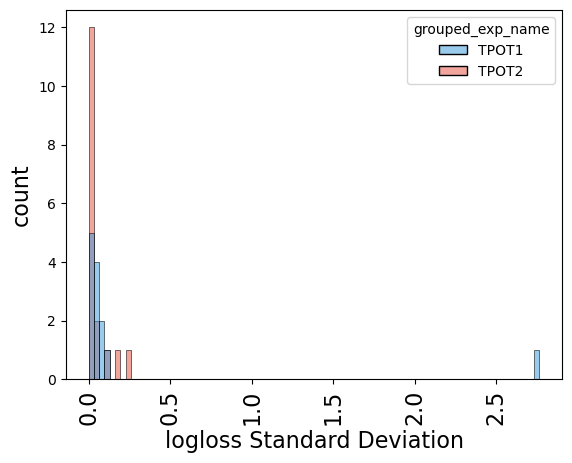

/tmp/ipykernel_70124/1443055911.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16)


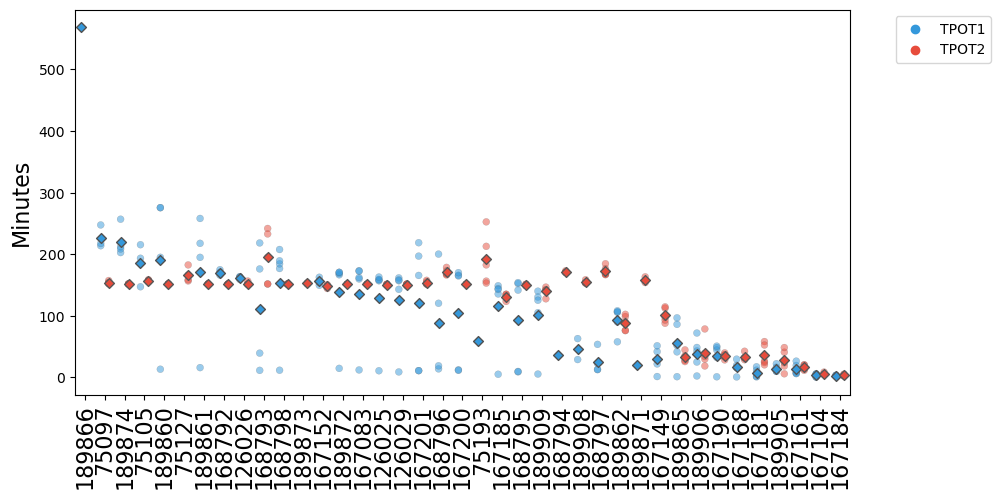

/tmp/ipykernel_70124/1443055911.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16)


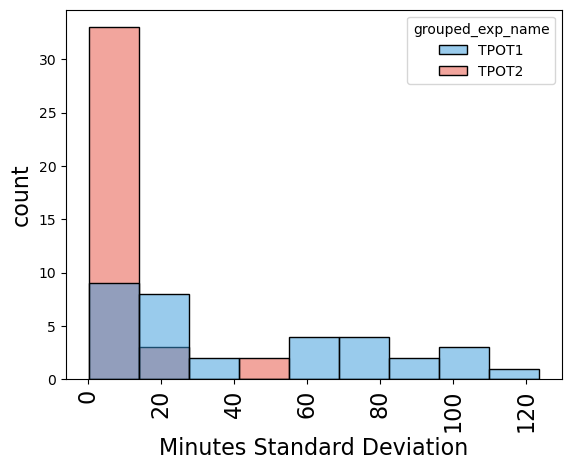

In [16]:
def make_strip_plots(df, metric, x='exp_name', log_scale=False, smaller_is_better=True, save_folder=None, name=None, taskid_palette=None, exp_pallete=exp_palette, method='dense'):
    df = df.copy(deep=True)
    df['taskid'] = df['taskid'].astype(str)


    df_summary =  df.groupby(['taskid', x])[metric].describe().reset_index()

    df_summary['mean_rank'] = df_summary.groupby(['taskid'])['mean'].rank(ascending=smaller_is_better, method=method)
    df_summary['mean_rounded'] = df_summary['mean'].round(3)
    df_summary['mean_rounded_rank'] = df_summary.groupby(['taskid'])['mean_rounded'].rank(ascending=smaller_is_better, method=method)


    mean_sorted_exp_names = df_summary.groupby([x])['mean'].describe().reset_index().sort_values('mean',ascending=False)[x].values.tolist()
    mean_sorted_exp_names.reverse()
    rank_sorted_exp_names = df_summary.groupby([x])['mean_rank'].describe().reset_index().sort_values('mean',ascending=True)[x].values
    rounded_rank_sorted_exp_names = df_summary.groupby([x])['mean_rounded_rank'].describe().reset_index().sort_values('mean',ascending=True)[x].values
    std_sorted_exp_names =  df_summary.groupby([x])['std'].describe().reset_index().sort_values('mean',ascending=True)[x].values
    mean_sorted_task_id = df_summary.groupby(['taskid'])['mean'].describe().reset_index().sort_values('mean',ascending=False)['taskid'].values.tolist()


    #mean scores by taskid
    fig, ax = plt.subplots(figsize=(10,5))
    sns.stripplot(x='taskid', y=metric, data=df, order=mean_sorted_task_id, hue=x,hue_order=mean_sorted_exp_names, ax=ax, alpha=0.5, size=5,dodge=True, jitter=False, palette=exp_pallete, edgecolors='white',linewidth=.2)
    sns.stripplot(x='taskid', y='mean', data=df_summary, order=mean_sorted_task_id, hue=x,hue_order=mean_sorted_exp_names, ax=ax, marker='D',alpha=1, size=5,dodge=True, jitter=False, palette=exp_pallete,edgecolors='black',linewidth=1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16)
    ax.set_ylabel(metric, fontsize=16)
    ax.set_xlabel('')
    if log_scale:
        ax.set_yscale('log')
    handles, labels = ax.get_legend_handles_labels()
    n = int(len(labels)/2)
    l = plt.legend(handles[0:n], labels[0:n],bbox_to_anchor=(1.05, 1), loc='upper left')
    if save_folder is not None:
        plt.savefig(f'{save_folder}/{name}_{metric}_by_taskid.svg', bbox_inches='tight')
        plt.savefig(f'{save_folder}/{name}_{metric}_by_taskid.png', bbox_inches='tight')
    plt.show()
    plt.close()

    #std
    fig, ax = plt.subplots()
    ax = sns.histplot(x='std', data=df_summary, hue=x, ax=ax, palette=exp_pallete)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16)
    ax.set_ylabel("count", fontsize=16)
    ax.set_xlabel(f'{metric} Standard Deviation', fontsize=16)
    #plt.legend( loc='upper left')
    if save_folder is not None:
        plt.savefig(f'{save_folder}/{name}_std.svg', bbox_inches='tight')
        plt.savefig(f'{save_folder}/{name}_std.png', bbox_inches='tight')
    plt.show()
    plt.close()

    # rank
    # fig,ax = plt.subplots()
    # ax = sns.stripplot(x=x, y='mean_rank', data=df_summary, order=mean_sorted_exp_names,hue='taskid', hue_order=mean_sorted_task_id, ax=ax)
    # #ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16)
    # ax.set_ylabel(f'{metric} Rank', fontsize=16)
    # ax.invert_yaxis()
    # ax.set_xlabel('')
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # if save_folder is not None:
    #     plt.savefig(f'{save_folder}/{name}_rank.svg', bbox_inches='tight')
    # plt.show()
    # plt.close()

    #rank box plot
    # fig,ax = plt.subplots()
    # ax = sns.boxplot(x=x, y='mean_rank', data=df_summary, order=mean_sorted_exp_names, ax=ax)
    # ax.set_ylabel(f'{metric} Rank', fontsize=16)
    # ax.invert_yaxis()
    # ax.set_xlabel('')
    # if save_folder is not None:
    #     plt.savefig(f'{save_folder}/{name}_rank_boxplot.svg', bbox_inches='tight')
    # plt.show()
    # plt.close()

        #sns histogram of counts of ranks per grouped_exp_name
    # fig,ax = plt.subplots()
    # ax = sns.histplot(data=df_summary, x='mean_rank', hue=x, multiple='stack', bins=20, ax=ax)
    # ax.set_xlabel(f'{metric} Rank', fontsize=16)
    # ax.set_ylabel('Count', fontsize=16)
    # ax.set_title(f'{metric} Rank Distribution', fontsize=16)
    # ax.tick_params(axis='both', which='major', labelsize=16)
    # if save_folder is not None:
    #     plt.savefig(f'{save_folder}/{name}_rank_hist.svg', bbox_inches='tight')
    # plt.show()
    # plt.close()

            #sns histogram of counts of ranks per grouped_exp_name
    # fig,ax = plt.subplots()
    # ax = sns.histplot(data=df_summary, x='mean_rounded_rank', hue=x, multiple='stack', bins=20, ax=ax)
    # ax.set_xlabel(f'{metric} Rank', fontsize=16)
    # ax.set_ylabel('Count', fontsize=16)
    # ax.set_title(f'{metric} rounded mean Rank Distribution', fontsize=16)
    # ax.tick_params(axis='both', which='major', labelsize=16)
    # if save_folder is not None:
    #     plt.savefig(f'{save_folder}/{name}_mean_rounded_rank_hist.svg', bbox_inches='tight')
    # plt.show()
    # plt.close()


method='average'
make_strip_plots(df[df['binary']==True], x='grouped_exp_name', metric='auroc', log_scale=False, smaller_is_better=False, save_folder=save_folder,  name='Binary', method=method)
make_strip_plots(df[df['binary']==False],x='grouped_exp_name', metric='logloss', log_scale=False, smaller_is_better=True, save_folder=save_folder, name='Multiclass',method=method)
df['Minutes'] = df['duration']
make_strip_plots(df, metric='Minutes', x='grouped_exp_name', log_scale=False, smaller_is_better=True, save_folder=save_folder,  name='Both_dur', taskid_palette=None, method=method)

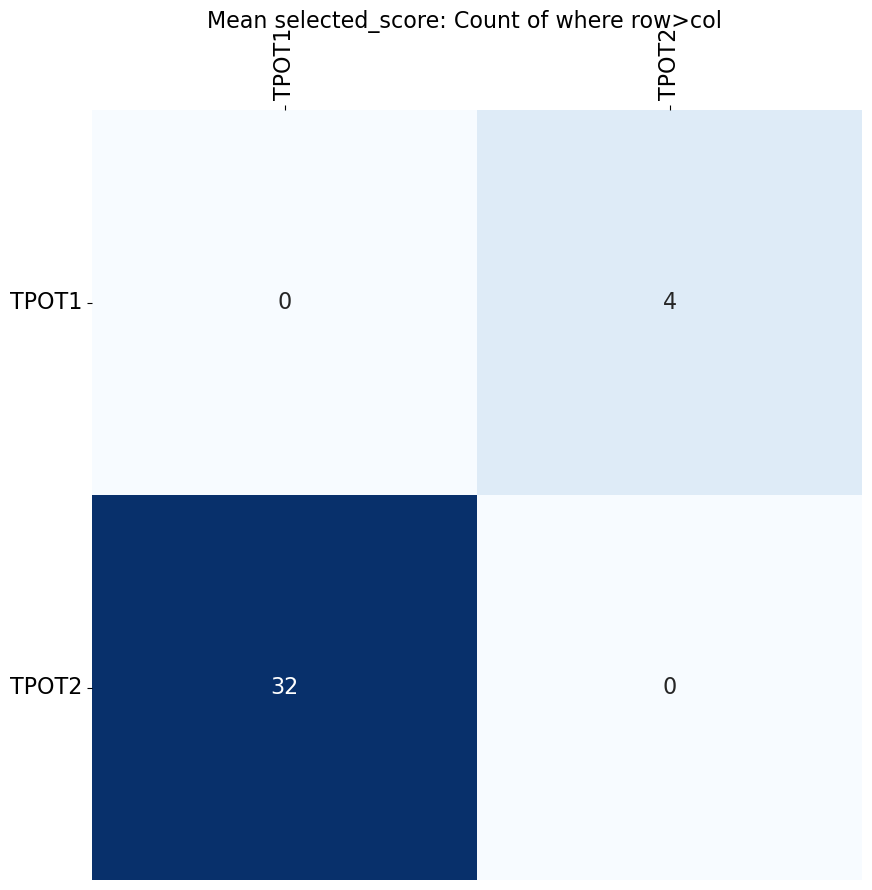

In [17]:
from itertools import product

def percent_change(initial, final):
    return 100*((final-initial)/abs(initial))

def better(score1, score2):
    return score1 > score2

def make_wins_heatmap(df, metric, save_folder=None):
    ### wins plot
    df = df.copy()
    fig = plt.figure(figsize=(10, 10))
    
    algorithms = df['grouped_exp_name'].unique()  
    
    df_summary =  df.groupby(['taskid', 'grouped_exp_name'])[metric].describe().reset_index()
    df_piv = df_summary.pivot(index='grouped_exp_name', columns='taskid', values='mean')
            
    wins = pd.DataFrame(index=algorithms, columns=algorithms)
    for alg1, alg2 in product(algorithms, algorithms):
        wins.loc[alg1, alg2] = sum([better(score1, score2) for score1, score2 in zip(df_piv.loc[alg1], df_piv.loc[alg2])])
    ax = sns.heatmap(data=wins.astype(int), annot=True, cmap='Blues',cbar=False,square = True, annot_kws={'size': 16})
    ax.xaxis.tick_top() # x axis on top
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=90)
    ax.tick_params(axis='both', which='major', labelsize=16)
    plt.yticks(rotation=0)
    #plt.title(f'Mean {name} : column > row*0.99 ', fontsize=16)
    fig.suptitle(f'Mean {metric}: Count of where row>col', fontsize=16)
    if save_folder is not None:
        plt.savefig(f'{save_folder}/{metric}_wins.svg', bbox_inches='tight')
        plt.savefig(f'{save_folder}/{metric}_wins.png', bbox_inches='tight')
    
make_wins_heatmap(df, metric='selected_score', save_folder=save_folder)

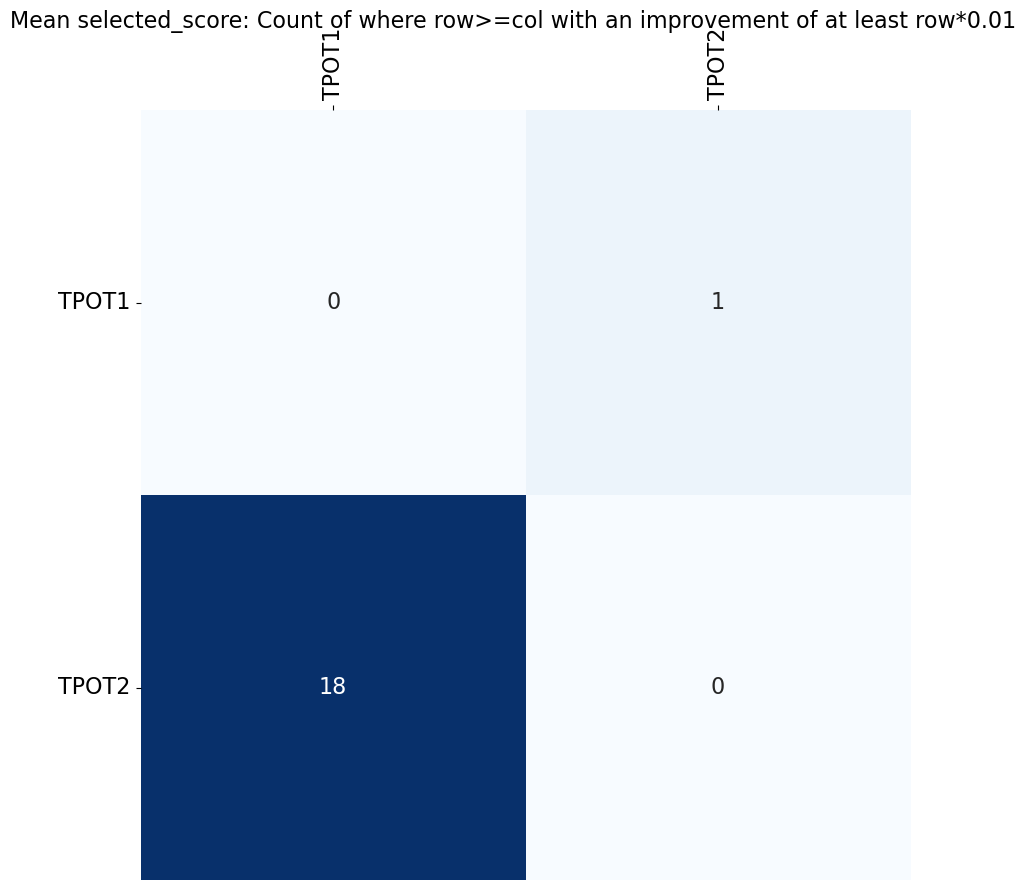

In [18]:
from itertools import product

def percent_change(initial, final):
    return 100*((final-initial)/abs(initial))

def better_by_percent(score1, score2, percent):
    return score1 >= score2 and percent_change(score2, score1)>=percent

def make_wins_heatmap(df, metric, save_folder=None, p=5):
    ### wins plot
    df = df.copy()
    fig = plt.figure(figsize=(10, 10))
    
    algorithms = df['grouped_exp_name'].unique()  
    
    df_summary =  df.groupby(['taskid', 'grouped_exp_name'])[metric].describe().reset_index()
    df_piv = df_summary.pivot(index='grouped_exp_name', columns='taskid', values='mean')
            
    wins = pd.DataFrame(index=algorithms, columns=algorithms)
    for alg1, alg2 in product(algorithms, algorithms):
        wins.loc[alg1, alg2] = sum([better_by_percent(score1, score2, p) for score1, score2 in zip(df_piv.loc[alg1], df_piv.loc[alg2])])
    ax = sns.heatmap(data=wins.astype(int), annot=True, cmap='Blues',cbar=False,square = True, annot_kws={'size': 16})
    ax.xaxis.tick_top() # x axis on top
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=90)
    ax.tick_params(axis='both', which='major', labelsize=16)
    plt.yticks(rotation=0)
    #plt.title(f'Mean {name} : column > row*0.99 ', fontsize=16)
    fig.suptitle(f'Mean {metric}: Count of where row>=col with an improvement of at least row*{p/100}', fontsize=16)
    if save_folder is not None:
        plt.savefig(f'{save_folder}/{metric}_wins.svg', bbox_inches='tight')
        plt.savefig(f'{save_folder}/{metric}_wins.png', bbox_inches='tight')
    
make_wins_heatmap(df, metric='selected_score', save_folder=save_folder, p=1)

In [19]:
df_summary = df.groupby(['taskid', 'grouped_exp_name'])["selected_score"].describe().reset_index()
df_piv = df_summary.pivot(index='grouped_exp_name', columns='taskid', values='mean')

In [21]:
diffs = df_piv.loc['TPOT1'] - df_piv.loc['TPOT2']

diffs[diffs>0].sort_values(ascending=False)

taskid
189908    0.080603
167149    0.000245
168798    0.000165
126025    0.000066
dtype: float64

In [22]:
df_piv[diffs[diffs>0].sort_values(ascending=False).index]

taskid,189908,167149,168798,126025
grouped_exp_name,,,,
TPOT1,-0.402356,0.999710,0.982426,0.929414
TPOT2,-0.482959,0.999464,0.982261,0.929348


In [24]:
x='grouped_exp_name'
smaller_is_better = True
metric = 'logloss'

df = df.copy(deep=True)
df['taskid'] = df['taskid'].astype(str)


df_summary =  df.groupby(['taskid', x])[metric].describe().reset_index()

df_summary['mean_rank'] = df_summary.groupby(['taskid'])['mean'].rank(ascending=smaller_is_better, method='dense')
df_summary['mean_rounded'] = df_summary['mean'].round(1)
df_summary['mean_rounded_rank'] = df_summary.groupby(['taskid'])['mean_rounded'].rank(ascending=smaller_is_better, method='dense')


mean_sorted_exp_names = df_summary.groupby([x])['mean'].describe().reset_index().sort_values('mean',ascending=False)[x].values.tolist()
mean_sorted_exp_names.reverse()
rank_sorted_exp_names = df_summary.groupby([x])['mean_rank'].describe().reset_index().sort_values('mean',ascending=True)[x].values
rounded_rank_sorted_exp_names = df_summary.groupby([x])['mean_rounded_rank'].describe().reset_index().sort_values('mean',ascending=True)[x].values
std_sorted_exp_names =  df_summary.groupby([x])['std'].describe().reset_index().sort_values('mean',ascending=True)[x].values
mean_sorted_task_id = df_summary.groupby(['taskid'])['mean'].describe().reset_index().sort_values('mean',ascending=False)['taskid'].values.tolist()

